In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Attention
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 加载训练数据
train_df = pd.read_csv('test_secondary_structure_cb513.csv')

# 先将数据集分为训练集和临时集（临时集包含验证集和测试集）
train_df, temp_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 然后从临时集分割出验证集和测试集
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"训练集样本数: {train_df.shape[0]}")
print(f"验证集样本数: {valid_df.shape[0]}")
print(f"测试集样本数: {test_df.shape[0]}")

# 标签映射（sst8 -> sst3）
sst8_to_sst3 = {
    'H': 'H', 'G': 'H', 'I': 'H',
    'E': 'E', 'B': 'E',
    'T': 'C', 'S': 'C', 'C': 'C'
}

def map_sst8_to_sst3(sst8):
    return ''.join([sst8_to_sst3.get(char, 'C') for char in sst8])

# 应用映射
train_df['sst3_mapped'] = train_df['sst8'].apply(map_sst8_to_sst3)
valid_df['sst3_mapped'] = valid_df['sst8'].apply(map_sst8_to_sst3)
test_df['sst3_mapped'] = test_df['sst8'].apply(map_sst8_to_sst3)

# 独热编码蛋白质序列
def one_hot_encode_sequences(sequences, max_len=None):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: idx for idx, aa in enumerate(amino_acids)}
    aa_to_int['X'] = len(amino_acids)  # 未知氨基酸编码

    integer_encoded = []
    for seq in sequences:
        encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in seq]
        integer_encoded.append(encoded)

    if not max_len:
        max_len = max(len(seq) for seq in integer_encoded)

    padded_encoded = tf.keras.preprocessing.sequence.pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=len(amino_acids)
    )

    one_hot_encoded = to_categorical(padded_encoded, num_classes=len(amino_acids) + 1)
    return one_hot_encoded, max_len

# 编码数据集
X_train, max_len = one_hot_encode_sequences(train_df['seq'])
X_valid, _ = one_hot_encode_sequences(valid_df['seq'], max_len)
X_test, _ = one_hot_encode_sequences(test_df['seq'], max_len)

print(f"训练集独热编码形状: {X_train.shape}")
print(f"验证集独热编码形状: {X_valid.shape}")
print(f"测试集独热编码形状: {X_test.shape}")

# 独热编码标签，仅保留 H 和 E 两类
def one_hot_encode_labels_two_classes(labels, max_len):
    sec_structs = ['H', 'E']
    struct_to_int = {s: idx for idx, s in enumerate(sec_structs)}

    integer_encoded = []
    for lbl in labels:
        # 仅保留 H 和 E，其他类别（如 'C'）映射为 'E'
        encoded = [struct_to_int[s] if s in struct_to_int else struct_to_int['E'] for s in lbl]
        integer_encoded.append(encoded)

    padded_encoded = pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=struct_to_int['E']
    )

    y = to_categorical(padded_encoded, num_classes=len(sec_structs))
    return y

# 编码标签
y_train = one_hot_encode_labels_two_classes(train_df['sst3_mapped'], max_len)
y_valid = one_hot_encode_labels_two_classes(valid_df['sst3_mapped'], max_len)
y_test = one_hot_encode_labels_two_classes(test_df['sst3_mapped'], max_len)

print(f"训练标签独热编码形状: {y_train.shape}")
print(f"验证标签独热编码形状: {y_valid.shape}")
print(f"测试标签独热编码形状: {y_test.shape}")


训练集样本数: 410
验证集样本数: 51
测试集样本数: 52
训练集独热编码形状: (410, 874, 21)
验证集独热编码形状: (51, 874, 21)
测试集独热编码形状: (52, 874, 21)
训练标签独热编码形状: (410, 874, 2)
验证标签独热编码形状: (51, 874, 2)
测试标签独热编码形状: (52, 874, 2)


In [3]:
import tensorflow as tf

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs {gpus} are available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using CPU.")

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] are available and configured.


In [4]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import mode
import tensorflow as tf

# 构建优化后的模型
input_layer = Input(shape=(max_len, X_train.shape[2]))

# 第一卷积层
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
conv1 = Dropout(0.4)(conv1)

# 第二卷积层
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv1)
conv2 = Dropout(0.4)(conv2)

# 第三卷积层
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(1e-4))(conv2)
conv3 = Dropout(0.4)(conv3)

# 双向LSTM层，返回序列
bi_lstm = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4)))(conv3)
bi_lstm = Dropout(0.3)(bi_lstm)

# Attention层
attention = Attention()([bi_lstm, bi_lstm])

# 输出层
output_layer = Dense(2, activation='softmax')(attention)


# 构建模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
optimizer = Adam(learning_rate=0.0007)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

# 添加EarlyStopping和ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 874, 21)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 874, 64)      4096        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 874, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 874, 128)     24704       dropout[0][0]                    
______________________________________________________________________________________________

In [5]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
# 模型评估
# 在验证集上评估模型性能。
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print(f"验证集 - 损失: {loss:.4f}, 准确率: {accuracy:.4f}, 精确率: {precision:.4f}, 召回率: {recall:.4f}")

验证集 - 损失: 0.1404, 准确率: 0.9420, 精确率: 0.9420, 召回率: 0.9420


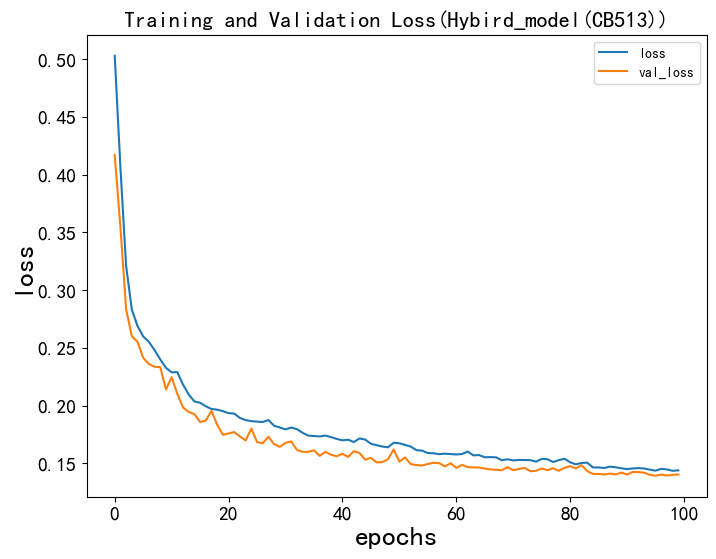

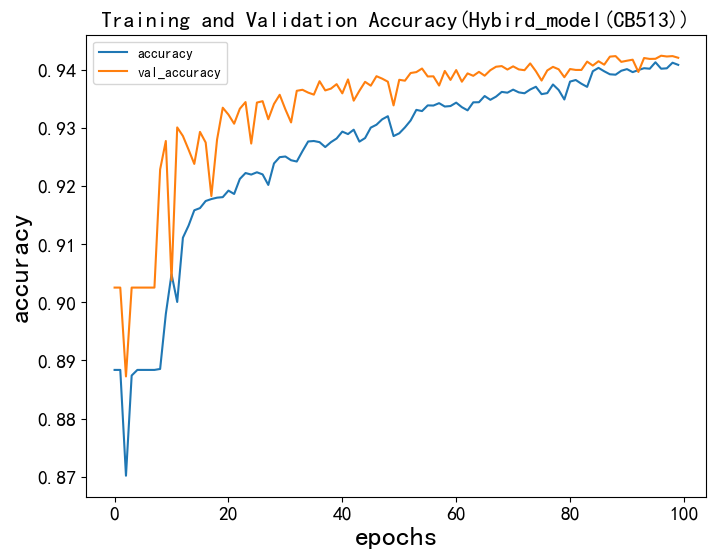

In [6]:
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建文件夹
folder = 'Final Result Plots(CB513)'
if not os.path.exists(folder):
    os.makedirs(folder)  # 如果文件夹不存在，则创建它

# Hybird_model
# 绘制损失和准确率
plt.figure(figsize=(8, 6))
# 损失函数
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss(Hybird_model(CB513))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('loss', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

# 保存并展示图像
plt.savefig(os.path.join(folder, 'loss_curve(Hybird_model(CB513)).png'), dpi=600)
plt.show()
plt.close()

# 准确率
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy(Hybird_model(CB513))', fontsize=16, weight='bold')  # 加粗标题
plt.xlabel('epochs', fontsize=20, weight='bold')  # 加粗x轴标签
plt.ylabel('accuracy', fontsize=20, weight='bold')  # 加粗y轴标签
plt.legend()

# 设置坐标轴数字的字体大小
plt.tick_params(axis='both', which='major', labelsize=14) 

plt.savefig(os.path.join(folder, 'accuracy_curve(Hybird_model(CB513)).png'), dpi=600)
plt.show()


In [7]:
model.save('Hybrid_model_CB513.h5')

Preparing data for feature importance analysis...
Computing position importance using permutation approach...
Original model accuracy: 0.9420
Processing position 0/874
Processing position 10/874
Processing position 20/874
Processing position 30/874
Processing position 40/874
Processing position 50/874
Processing position 60/874
Processing position 70/874
Processing position 80/874
Processing position 90/874
Processing position 100/874
Processing position 110/874
Processing position 120/874
Processing position 130/874
Processing position 140/874
Processing position 150/874
Processing position 160/874
Processing position 170/874
Processing position 180/874
Processing position 190/874
Processing position 200/874
Processing position 210/874
Processing position 220/874
Processing position 230/874
Processing position 240/874
Processing position 250/874
Processing position 260/874
Processing position 270/874
Processing position 280/874
Processing position 290/874
Processing position 300/874
P

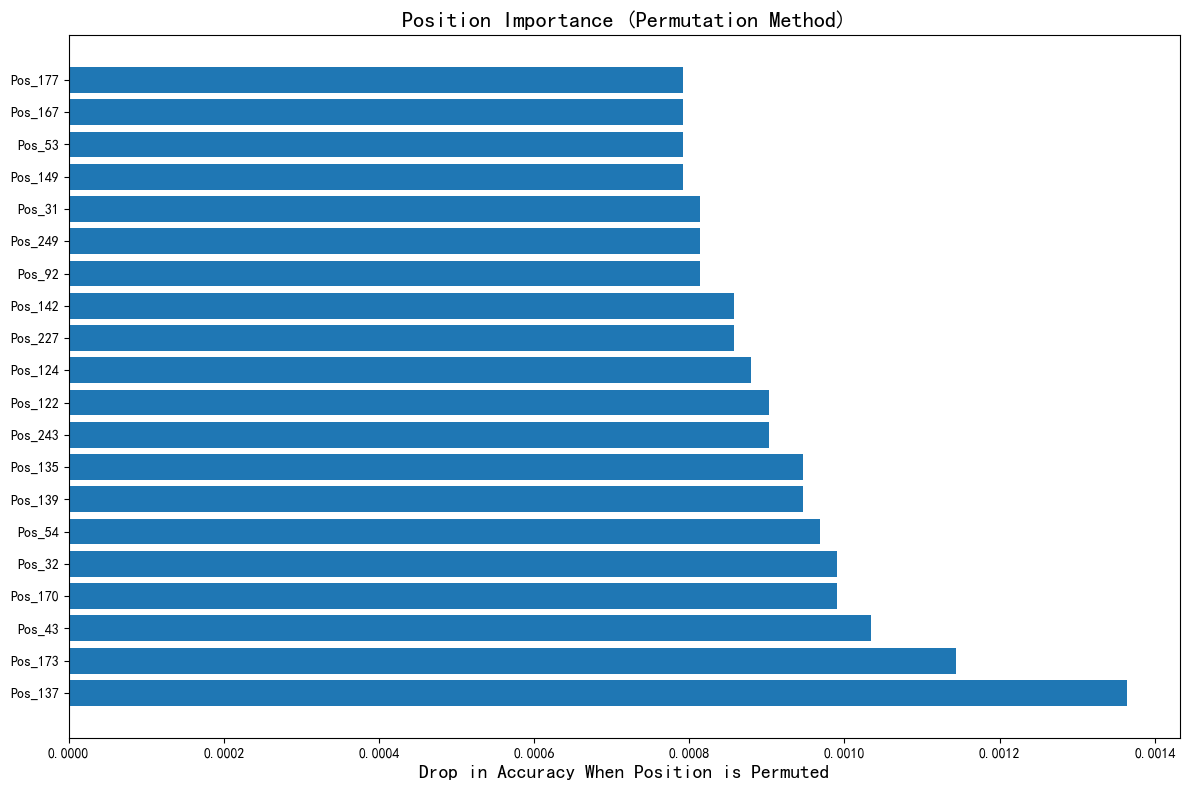

Generating Summary Plot...


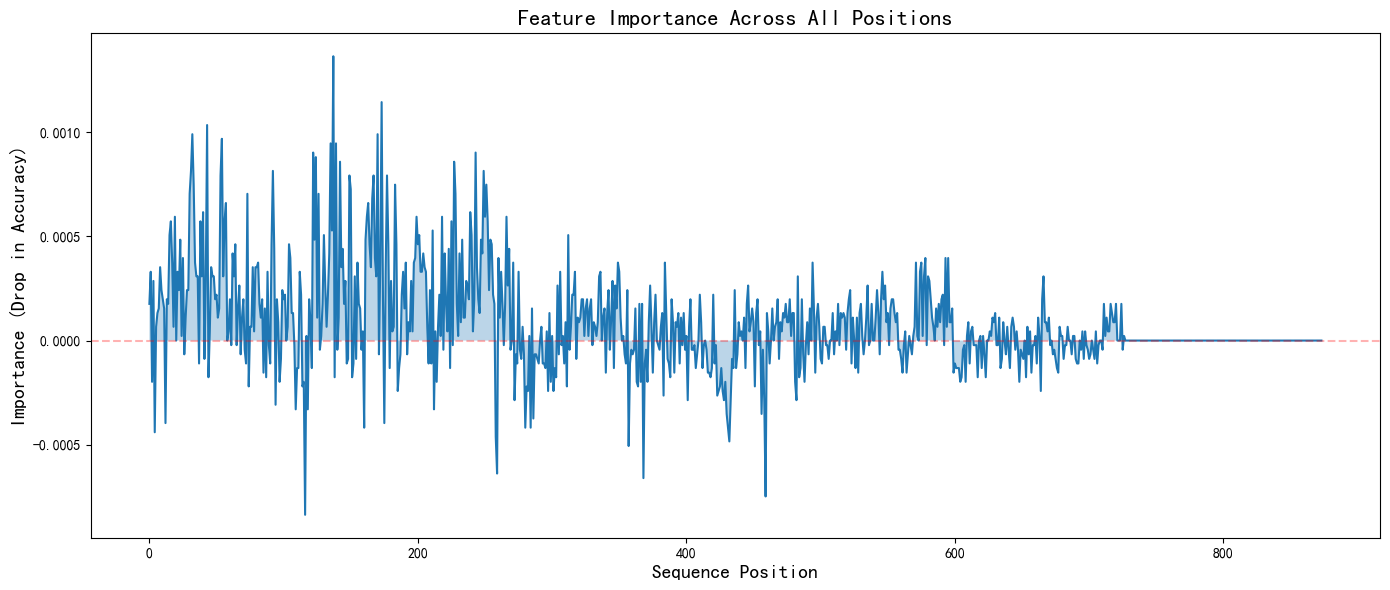

Generating Dependency Plot...


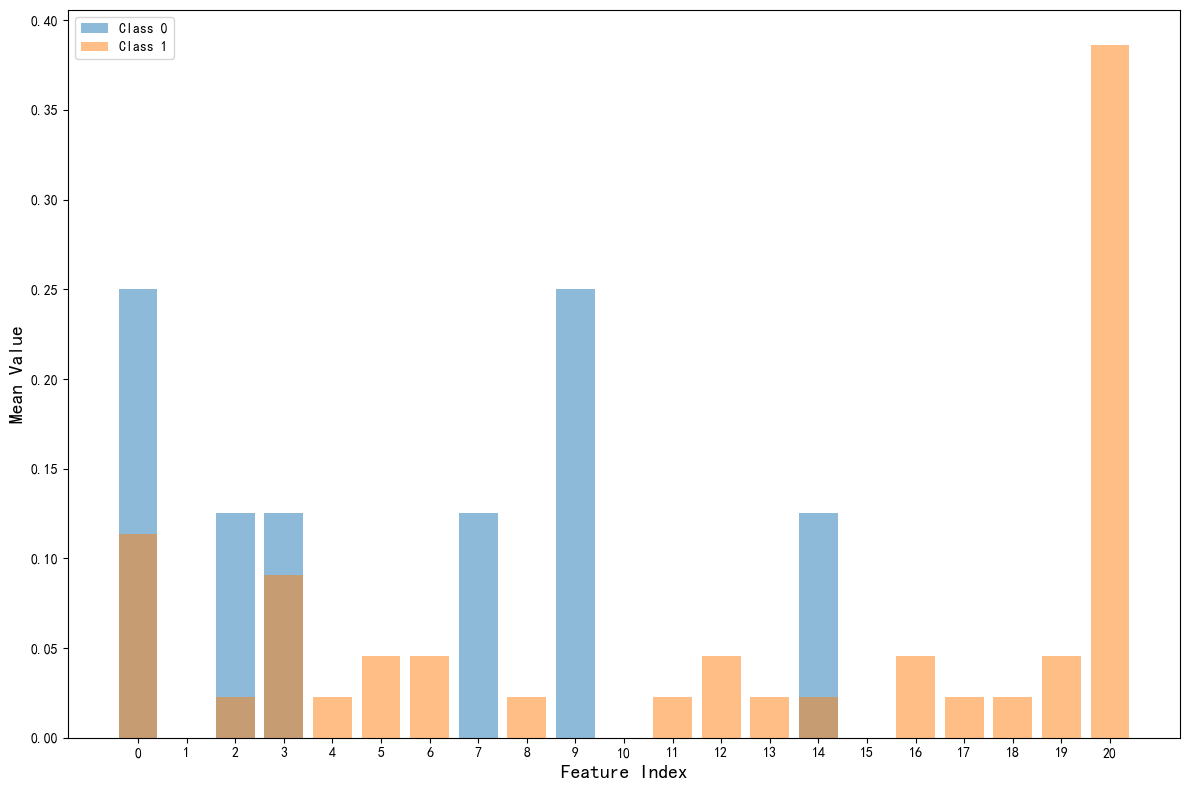

Generating Force-like Plot...


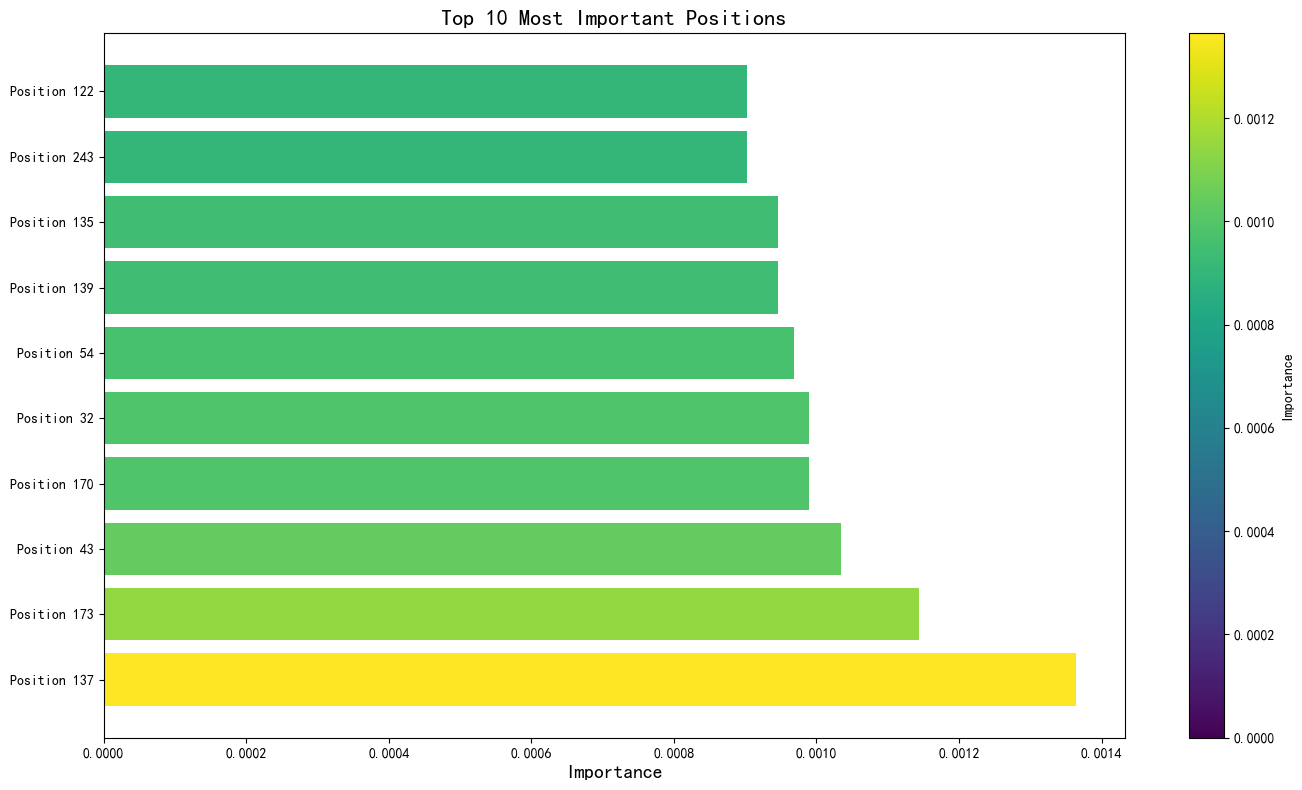

Generating Decision-like Plot...


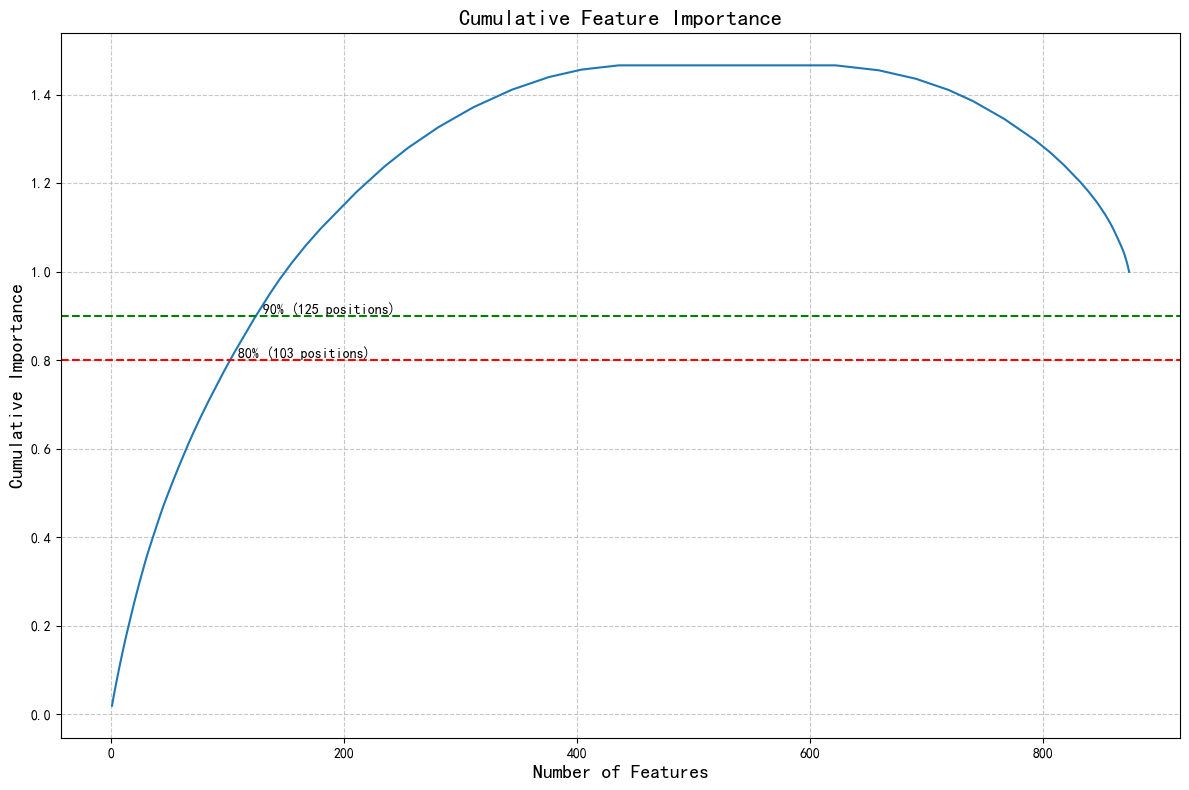

All feature importance plots generated and saved to Feature_Importance_CB513 directory


In [12]:
# Import required libraries for feature importance analysis
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Create directory for visualization plots
plots_dir = 'Feature_Importance_CB513'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

print("Preparing data for feature importance analysis...")

# Take a sample to make the analysis tractable
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(X_test.shape[0], size=min(sample_size, X_test.shape[0]), replace=False)
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

# Create a wrapper for permutation importance to work with TensorFlow models
class KerasWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        return self.model.predict(X)
        
    def score(self, X, y):
        y_pred = self.model.predict(X)
        
        # Handle models that return a list of outputs (multi-headed models)
        if isinstance(y_pred, list):
            # Use the first output for feature importance analysis
            y_pred = y_pred[0]
        
        # Convert predictions to class indices - modified for multi-output
        if len(y_pred.shape) > 2:  # For 3D outputs (batch, seq_len, classes)
            # Flattening the sequence dimension for overall accuracy
            y_pred_flat = np.argmax(y_pred.reshape(-1, y_pred.shape[-1]), axis=1)
            y_true_flat = np.argmax(y.reshape(-1, y.shape[-1]), axis=1)
            return np.mean(y_pred_flat == y_true_flat)
        else:
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y, axis=1)
            return np.mean(y_pred_classes == y_true_classes)

# Wrap the model
wrapped_model = KerasWrapper(model)

print("Computing position importance using permutation approach...")

# We'll analyze feature importance by sequence position rather than individual amino acids
# This gives us a more manageable number of features

# Function to permute a specific position across all samples
def permute_position(X, position):
    X_permuted = X.copy()
    # Shuffle the amino acid values at this position across all samples
    np.random.shuffle(X_permuted[:, position, :])
    return X_permuted

# Store original performance
original_score = wrapped_model.score(X_test_sample, y_test_sample)
print(f"Original model accuracy: {original_score:.4f}")

# Calculate importance by position
positions = X_test_sample.shape[1]
position_importances = []

# For each position, permute it and see how much the performance drops
for pos in range(positions):
    if pos % 10 == 0:
        print(f"Processing position {pos}/{positions}")
    
    # Permute the position
    X_permuted = permute_position(X_test_sample, pos)
    
    # Calculate new score
    new_score = wrapped_model.score(X_permuted, y_test_sample)
    
    # Importance is the drop in performance
    importance = original_score - new_score
    position_importances.append(importance)

# Convert to numpy array
position_importances = np.array(position_importances)

print("Generating visualizations...")

# 1. Bar Plot - Position Importance
print("Generating Bar Plot...")
plt.figure(figsize=(12, 8))

# Get top positions by importance
top_k = 20
top_positions = np.argsort(position_importances)[-top_k:]

plt.barh(range(top_k), position_importances[top_positions][::-1])
plt.yticks(range(top_k), [f"Pos_{i}" for i in top_positions][::-1])
plt.title('Position Importance (Permutation Method)', fontsize=16, fontweight='bold')
plt.xlabel('Drop in Accuracy When Position is Permuted', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'bar_plot.png'), dpi=600)
plt.show()

# 2. Summary Plot - Importance across all positions
print("Generating Summary Plot...")
plt.figure(figsize=(14, 6))

# Plot importance across all positions
plt.plot(range(positions), position_importances)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.fill_between(range(positions), position_importances, alpha=0.3)
plt.title('Feature Importance Across All Positions', fontsize=16, fontweight='bold')
plt.xlabel('Sequence Position', fontsize=14)
plt.ylabel('Importance (Drop in Accuracy)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'summary_plot.png'), dpi=600)
plt.show()

# 3. Dependency-style plot - Position values vs importance
print("Generating Dependency Plot...")

# Create a dependency-style visualization for the most important position
most_important_pos = np.argmax(position_importances)

# We'll examine what values are present at this position and their distribution
plt.figure(figsize=(12, 8))

# Determine the number of classes in your model's output
# For multi-class classification, get unique classes
y_pred = wrapped_model.predict(X_test_sample)
if isinstance(y_pred, list):
    y_pred = y_pred[0]

# If y_pred is 3D (batch, seq_len, classes), we'll focus on the most important position
if len(y_pred.shape) > 2:
    y_pred = y_pred[:, most_important_pos, :]
    y_true_sample = y_test_sample[:, most_important_pos, :]
else:
    y_true_sample = y_test_sample

# Get distributions based on number of classes
num_classes = y_true_sample.shape[-1]

# Check if this is a binary classification
if num_classes == 2:
    # Get the feature values at this position for each class
    class_0_indices = np.where(np.argmax(y_true_sample, axis=1) == 0)[0]
    class_1_indices = np.where(np.argmax(y_true_sample, axis=1) == 1)[0]

    # Calculate mean amino acid distribution for each class at this position
    class_0_dist = X_test_sample[class_0_indices, most_important_pos, :].mean(axis=0)
    class_1_dist = X_test_sample[class_1_indices, most_important_pos, :].mean(axis=0)

    # Use amino acid indices for x-axis if appropriate
    if X_test_sample.shape[2] == 20:  # If likely representing amino acids
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        x = range(len(amino_acids))
        
        # Plot distributions
        plt.bar(x, class_0_dist, alpha=0.5, label=f'Class 0')
        plt.bar(x, class_1_dist, alpha=0.5, label=f'Class 1')
        plt.title(f'Amino Acid Distribution at Position {most_important_pos}', fontsize=16, fontweight='bold')
        plt.xlabel('Amino Acid', fontsize=14)
        plt.ylabel('Mean Frequency', fontsize=14)
        plt.xticks(x, list(amino_acids))
    else:
        # For non-amino acid features
        x = range(X_test_sample.shape[2])
        plt.bar(x, class_0_dist, alpha=0.5, label=f'Class 0')
        plt.bar(x, class_1_dist, alpha=0.5, label=f'Class 1')
        plt.xlabel('Feature Index', fontsize=14)
        plt.ylabel('Mean Value', fontsize=14)
        plt.xticks(x)
else:
    # For multi-class scenario, compare the top 2 classes or use another approach
    # Get the predictions for this position
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true_sample, axis=1)
    
    # Separate correctly and incorrectly classified samples
    correct_indices = np.where(y_pred_classes == y_true_classes)[0]
    incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]
    
    correct_dist = X_test_sample[correct_indices, most_important_pos, :].mean(axis=0) if len(correct_indices) > 0 else np.zeros(X_test_sample.shape[2])
    incorrect_dist = X_test_sample[incorrect_indices, most_important_pos, :].mean(axis=0) if len(incorrect_indices) > 0 else np.zeros(X_test_sample.shape[2])
    
    # For amino acid representation
    if X_test_sample.shape[2] == 20:
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        x = range(len(amino_acids))
        plt.bar(x, correct_dist, alpha=0.5, label='Correct Predictions')
        plt.bar(x, incorrect_dist, alpha=0.5, label='Incorrect Predictions')
        plt.title(f'Amino Acid Distribution at Position {most_important_pos}', fontsize=16, fontweight='bold')
        plt.xlabel('Amino Acid', fontsize=14)
        plt.ylabel('Mean Frequency', fontsize=14)
        plt.xticks(x, list(amino_acids))
    else:
        # For non-amino acid features
        x = range(X_test_sample.shape[2])
        plt.bar(x, correct_dist, alpha=0.5, label='Correct Predictions')
        plt.bar(x, incorrect_dist, alpha=0.5, label='Incorrect Predictions')
        plt.xlabel('Feature Index', fontsize=14)
        plt.ylabel('Mean Value', fontsize=14)
        plt.xticks(x)

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'dependency_plot.png'), dpi=600)
plt.show()

# 4. Force-like Plot - Contribution of top positions
print("Generating Force-like Plot...")
plt.figure(figsize=(14, 8))

# Get top 10 positions
top_10_pos = np.argsort(position_importances)[-10:]
top_10_imp = position_importances[top_10_pos]

# Handle the case where importance values might be all zero
if np.all(top_10_imp == 0):
    max_imp = 1.0  # Set a default value to avoid division by zero
else:
    max_imp = top_10_imp.max()

# Create a horizontal bar chart with colors based on importance
colors = plt.cm.viridis(top_10_imp / max_imp)
bars = plt.barh(range(len(top_10_pos)), top_10_imp[::-1], color=colors[::-1])
plt.yticks(range(len(top_10_pos)), [f"Position {i}" for i in top_10_pos][::-1])
plt.title('Top 10 Most Important Positions', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max_imp)), 
            label='Importance')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'force_plot.png'), dpi=600)
plt.show()

# 5. Decision-like Plot - Cumulative importance
print("Generating Decision-like Plot...")
plt.figure(figsize=(12, 8))

# Sort positions by importance
sorted_indices = np.argsort(position_importances)[::-1]
cumulative_importance = np.cumsum(position_importances[sorted_indices])

# Handle edge cases for normalization
if cumulative_importance[-1] <= 0:
    # If all zeros or negative values, use uniform distribution
    cumulative_importance = np.linspace(0, 1, len(cumulative_importance))
else:
    # Normalize to get percentages
    cumulative_importance = cumulative_importance / cumulative_importance[-1]

plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
plt.title('Cumulative Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)

# Find where we reach 80% and 90% importance with safety checks
x_80_indices = np.where(cumulative_importance >= 0.8)[0]
if len(x_80_indices) > 0:
    x_80 = x_80_indices[0] + 1
    plt.text(x_80, 0.8, f' 80% ({x_80} positions)', verticalalignment='bottom')

x_90_indices = np.where(cumulative_importance >= 0.9)[0]
if len(x_90_indices) > 0:
    x_90 = x_90_indices[0] + 1
    plt.text(x_90, 0.9, f' 90% ({x_90} positions)', verticalalignment='bottom')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'decision_plot.png'), dpi=600)
plt.show()

print(f"All feature importance plots generated and saved to {plots_dir} directory")